# (WIP) 04. PyTorch Custom Datasets

* Bring in custom dataset
* Try TinyVGG on custom dataset (conv layers etc) - https://poloclub.github.io/cnn-explainer/
* compare custom dataset on and off GPU
* Use TensorBoard integration in VSCode - can sync this up with Weights & Biases

In [1]:
import torch
from torch import nn

In [2]:
print(torch.__version__)

1.10.0


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load data 

### Option 1 - Using `ImageFolder`

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
train_dir = "data/10_whole_foods/train"
test_dir = "data/10_whole_foods/test"

In [6]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

Visualize the transforms...

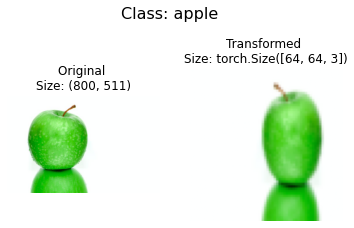

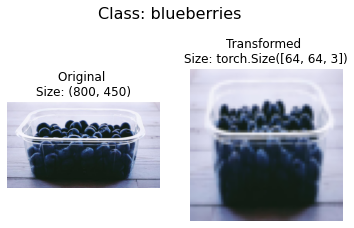

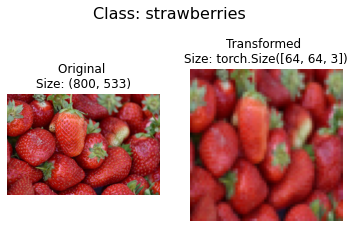

In [18]:
# Import random image and transform 
from PIL import Image
import random
import matplotlib.pyplot as plt
import pathlib

# Get all image paths
image_path_list = list(pathlib.Path("data/10_whole_foods/").glob("*/*/*.jpg"))

def plot_transformed_images(image_paths, transform, n=3):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
    """
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            transformed_image = transform(f).permute(1, 2, 0) # change shape of image to suit matplotlib
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [19]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 654
     Root location: 10_whole_foods/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 164
     Root location: 10_whole_foods/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [20]:
class_names = train_data.classes
class_names

['apple',
 'banana',
 'beef',
 'blueberries',
 'carrots',
 'chicken_wings',
 'egg',
 'honey',
 'mushrooms',
 'strawberries']

Original shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


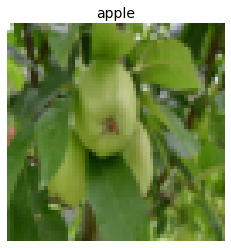

In [23]:
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1, 2, 0) # need to change shape for Matplotlib
print(f"Original shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [24]:
img, label

(tensor([[[0.9961, 0.6706, 0.2078,  ..., 0.1176, 0.1686, 0.1922],
          [0.9882, 0.7961, 0.2392,  ..., 0.1059, 0.1490, 0.2235],
          [0.6588, 0.5804, 0.2275,  ..., 0.1098, 0.1490, 0.2392],
          ...,
          [0.2275, 0.1647, 0.1373,  ..., 0.2549, 0.2588, 0.4784],
          [0.2275, 0.1686, 0.1490,  ..., 0.3020, 0.2314, 0.4510],
          [0.2275, 0.1686, 0.1490,  ..., 0.2980, 0.2235, 0.3804]],
 
         [[0.9961, 0.7216, 0.3490,  ..., 0.2235, 0.2471, 0.1882],
          [0.9922, 0.8314, 0.3765,  ..., 0.2157, 0.2196, 0.2196],
          [0.7451, 0.6784, 0.3765,  ..., 0.2157, 0.2039, 0.2471],
          ...,
          [0.3804, 0.3098, 0.2706,  ..., 0.3529, 0.3608, 0.5882],
          [0.3765, 0.3098, 0.2824,  ..., 0.4078, 0.3333, 0.5529],
          [0.3804, 0.3098, 0.2824,  ..., 0.4118, 0.3255, 0.4824]],
 
         [[0.9961, 0.6235, 0.0353,  ..., 0.0353, 0.0706, 0.0431],
          [0.9922, 0.7765, 0.0745,  ..., 0.0157, 0.0275, 0.0627],
          [0.5686, 0.4745, 0.0471,  ...,

In [25]:
# Turn images into data loaders
train_dataloader = DataLoader(train_data, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, num_workers=1, shuffle=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8aea4df730>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8aea4dfc40>)

In [26]:
img, label = next(iter(train_dataloader))
img.shape, label.shape # batch size is now 1 (try changing the batch_size parameter above)

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## Option 2: Custom data loader

We're going to recreate `torchvision.datasets.ImageFolder()` - https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder

* TK - why use this?
* TK - what's pros and cons? (e.g. more prone to errors but get full customization, have to write more code)

In [27]:
import pathlib
import random
import torch
import os

from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Make function to find classes in target directory
# (assumes target directory is in standard image format)
def find_classes(directory: str) -> Tuple[List[str], Dict[str, str]]:
    """Finds the class folder names in a target directory.

    Args:
        directory ([str]): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, str]]: (list_of_class_names, dict(idx: class_name...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
find_classes(train_dir)

(['apple',
  'banana',
  'beef',
  'blueberries',
  'carrots',
  'chicken_wings',
  'egg',
  'honey',
  'mushrooms',
  'strawberries'],
 {'apple': 0,
  'banana': 1,
  'beef': 2,
  'blueberries': 3,
  'carrots': 4,
  'chicken_wings': 5,
  'egg': 6,
  'honey': 7,
  'mushrooms': 8,
  'strawberries': 9})

In [30]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir, transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        self.transform = transform
        self.class_names, self.class_to_idx = find_classes(targ_dir)

    # Make function to load images
    def load_image(self, index) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path) 

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label
        else:
            return img, class_idx

In [31]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(test_dir, transform=test_transforms)
len(train_data_custom), len(test_data_custom)


(654, 164)

### TK - Create a function to display random images

In [32]:
def display_random_images(dataset, n=10, classes=None, seed=None):
  if n > 10:
    n = 10
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10.")

  if seed:
    random.seed(seed)  

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through samples and display
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # Min-max scale
    sample_min, sample_max = targ_image.min(), targ_image.max()
    sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

    # Adjust for shape (colour, height, width) -> (height, width, colour)
    sample_adjust = sample_scaled.permute(1, 2, 0)
    # print(sample_adjust)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(sample_adjust)
    plt.axis("off")
    if classes:
      plt.title(classes[targ_label])

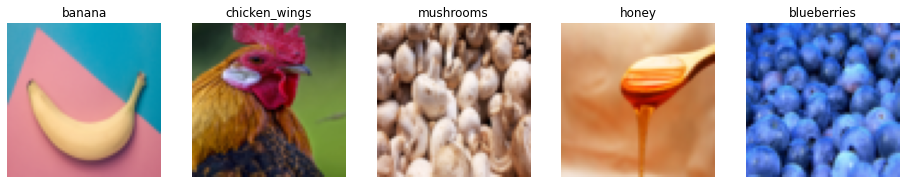

In [33]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, n=5, classes=class_names)

For display purposes, n shouldn't be larger than 10, setting to 10.


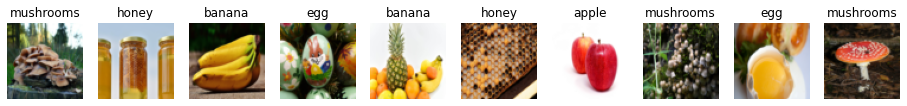

In [34]:
# Test custom dataset images
display_random_images(train_data_custom, n=12, classes=class_names)

TK - what do each of the arguments in the DataLoader do?

In [35]:
# Turn image datasets into data loaders
train_dataloader_custom = DataLoader(train_data_custom, batch_size=1, num_workers=1, shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom, batch_size=1, num_workers=1, shuffle=True)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f8ae83fbc10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8ae83fbd30>)

In [36]:
img, label = next(iter(train_dataloader_custom))
img.shape, label.shape # batch size is now 1 (try changing the batch_size parameter above)

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## TK Other forms of Augmentation (transforms)

* RandAugment (random) - https://pytorch.org/vision/master/auto_examples/plot_transforms.html#randaugment
* TrivialAugment

In [37]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandAugment(num_ops=1, magnitude=5), 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

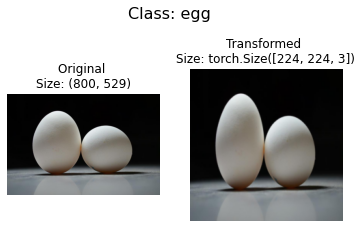

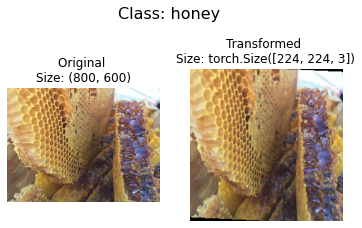

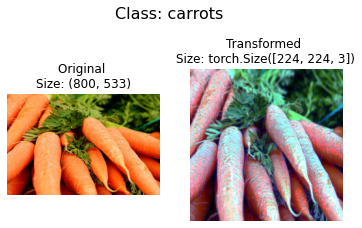

In [38]:
# Plot random images
image_path_list = list(pathlib.Path("data/10_whole_foods/").glob("*/*/*.jpg"))

plot_transformed_images(image_paths=image_path_list,
    transform=train_transforms,
    n=3
)


## TK - Model without data augmentation

In [39]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [40]:
# Load data
train_data_simple = datasets.ImageFolder(train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(test_dir, transform=simple_transform)

# Turn data into DataLoaders
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=32, 
                                     shuffle=True, 
                                     num_workers=8)
test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=32, 
                                    shuffle=True, 
                                    num_workers=8)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f8aea1c80a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8aea1a13a0>)

### Create model

In [41]:
class TinyVGG(nn.Module):
    def __init__(self, input_size, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                out_channels=hidden_units,
                kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, # get this by printing the shape of the outputs of each layer
                      out_features=hidden_units))
    
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        #return self.classifier(self.conv_block(self.conv_block(x)))

model_0 = TinyVGG(input_size=3, # number of colour channels
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=10, bias=True)
  )
)

In [42]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  --                        --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Create train & test functions

TK - after 04, functionize everything

In [43]:
from tqdm import tqdm

In [44]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Send data to GPU
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. Calculate metrics
        train_loss += loss.item()
        y_pred_class = torch.softmax(y_pred, dim=1).argmax(dim=1)
        # print(f"y: \n{y}\ny_pred_class:{y_pred_class}")
        # print(f"y argmax: {y_pred.argmax(dim=1)}")
        # print(f"Equal: {(y_pred_class == y)}")
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        # print(f"batch: {batch} train_acc: {train_acc}")

    # Adjust returned metrics
    return train_loss/len(dataloader), train_acc/len(dataloader)

In [45]:
def test_step(model, dataloader, loss_fn):
    model.eval() # put model in eval mode
    test_loss_total, test_acc = 0, 0
    # Turn on inference context manager
    for batch, (X, y) in enumerate(dataloader):
        # Send data to GPU
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        
        with torch.inference_mode():
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss
            test_loss = loss_fn(test_pred, y)

            # Calculate metrics
            test_loss_total += test_loss.item()
            test_acc += torch.eq(test_pred.argmax(dim=1), y).sum().item()/len(test_pred)
            
    # Adjust metrics
    test_loss_total /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss_total, test_acc

In [46]:
def train(model, 
          train_dataloader, 
          test_dataloader, 
          optimizer,
          loss_fn=nn.CrossEntropyLoss(),
          epochs=5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [47]:
# Train
from timeit import default_timer as timer 
start_time = timer()
epochs = 5
results = train(model=model_0, 
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    optimizer=torch.optim.Adam(model_0.parameters(), lr=0.001),
    epochs=5,
    loss_fn=nn.CrossEntropyLoss())
end_time = timer()
print(f"Total training time: {end_time-start_time}")

 20%|██        | 1/5 [00:18<01:15, 18.76s/it]

Length test dataloader: 6
Epoch: 1 | train_loss: 2.3099 | train_acc: 0.1012 | test_loss: 2.3008 | test_acc: 0.1146


 40%|████      | 2/5 [00:38<00:58, 19.59s/it]

Length test dataloader: 6
Epoch: 2 | train_loss: 2.2986 | train_acc: 0.1218 | test_loss: 2.2991 | test_acc: 0.1146


 60%|██████    | 3/5 [00:59<00:40, 20.18s/it]

Length test dataloader: 6
Epoch: 3 | train_loss: 2.2918 | train_acc: 0.1125 | test_loss: 2.3154 | test_acc: 0.1094


 80%|████████  | 4/5 [01:19<00:20, 20.17s/it]

Length test dataloader: 6
Epoch: 4 | train_loss: 2.2720 | train_acc: 0.1531 | test_loss: 2.2574 | test_acc: 0.1615


100%|██████████| 5/5 [01:39<00:00, 19.92s/it]

Length test dataloader: 6
Epoch: 5 | train_loss: 2.1885 | train_acc: 0.1971 | test_loss: 2.2036 | test_acc: 0.1458
Total training time: 99.58987294498365


In [48]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

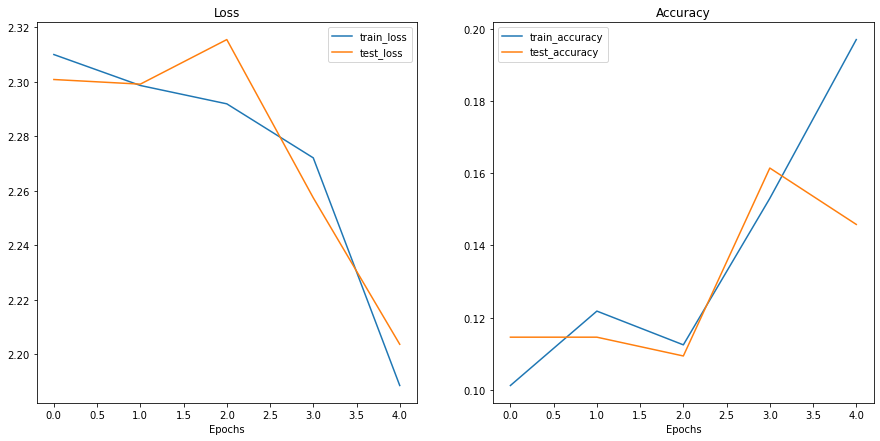

In [49]:
plot_loss_curves(results)

## TK - Model with Data Augmentation

In [50]:
train_transform_random = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandAugment(num_ops=1, magnitude=5),
    transforms.ToTensor() 
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [51]:
# Load data
train_data_random = datasets.ImageFolder(train_dir, transform=train_transform_random)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# Turn data into DataLoaders
import os
NUM_WORKERS = os.cpu_count()
train_dataloader_random = DataLoader(train_data_random, 
                                     batch_size=32, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data_simple, 
                            batch_size=32, 
                            shuffle=True, 
                            num_workers=NUM_WORKERS)

train_dataloader_random, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8ae84e3d90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8ae81efc40>)

In [52]:
model_1 = TinyVGG(input_size=3,
    hidden_units=10,
    output_shape=10).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=10, bias=True)
  )
)

In [55]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [56]:
# Train
from timeit import default_timer as timer 
start_time = timer()
epochs = 5
results = train(model=model_1, 
    train_dataloader=train_dataloader_random,
    test_dataloader=test_dataloader,
    optimizer=torch.optim.Adam(model_1.parameters(), lr=0.001),
    epochs=5,
    loss_fn=nn.CrossEntropyLoss())
end_time = timer()
print(f"Total training time: {end_time-start_time}")

 20%|██        | 1/5 [00:18<01:12, 18.00s/it]

Length test dataloader: 6
Epoch: 1 | train_loss: 2.3061 | train_acc: 0.1278 | test_loss: 2.2885 | test_acc: 0.1198


 40%|████      | 2/5 [00:35<00:52, 17.57s/it]

Length test dataloader: 6
Epoch: 2 | train_loss: 2.2659 | train_acc: 0.1399 | test_loss: 2.2619 | test_acc: 0.1510


 60%|██████    | 3/5 [00:53<00:35, 17.93s/it]

Length test dataloader: 6
Epoch: 3 | train_loss: 2.2197 | train_acc: 0.1754 | test_loss: 2.1338 | test_acc: 0.1875


 80%|████████  | 4/5 [01:11<00:18, 18.05s/it]

Length test dataloader: 6
Epoch: 4 | train_loss: 2.1384 | train_acc: 0.2211 | test_loss: 2.0938 | test_acc: 0.2448


100%|██████████| 5/5 [01:30<00:00, 18.02s/it]

Length test dataloader: 6
Epoch: 5 | train_loss: 2.0756 | train_acc: 0.2870 | test_loss: 2.1124 | test_acc: 0.2500
Total training time: 90.12192492399481


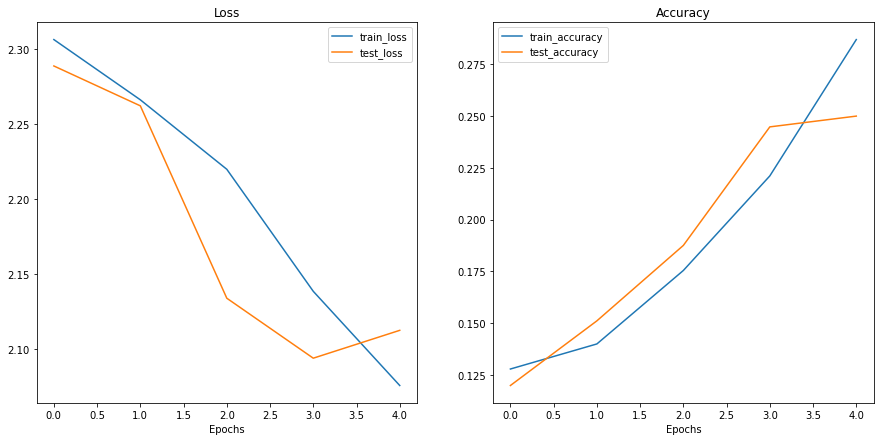

In [57]:
plot_loss_curves(results)

## TODO
* Finsh off transforms - RandAugment expects torch.uint8 as input - https://pytorch.org/vision/master/generated/torchvision.transforms.RandAugment.html#torchvision.transforms.RandAugment
* ~~Build a model without data augmentation~~
### Next: 
* Functionize train and test functions to make them more robust...
* Build a model with data augmentation
* Compare the performance and loss curves of each model

# Next notebook
* Build a model on a small subset of the data (e.g. 10 images per class)
* Build a model on a larger subset of the data (e.g. 100 images per class)
* Track results with PyTorch profiler
* Introduce transfer learning (beat the original model)



In [85]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [86]:
walk_through_dir("10_whole_foods")

There are 2 directories and 1 images in '10_whole_foods'.
There are 10 directories and 0 images in '10_whole_foods/test'.
There are 0 directories and 17 images in '10_whole_foods/test/carrots'.
There are 0 directories and 11 images in '10_whole_foods/test/mushrooms'.
There are 0 directories and 17 images in '10_whole_foods/test/apple'.
There are 0 directories and 10 images in '10_whole_foods/test/strawberries'.
There are 0 directories and 19 images in '10_whole_foods/test/blueberries'.
There are 0 directories and 20 images in '10_whole_foods/test/banana'.
There are 0 directories and 21 images in '10_whole_foods/test/beef'.
There are 0 directories and 15 images in '10_whole_foods/test/egg'.
There are 0 directories and 19 images in '10_whole_foods/test/honey'.
There are 0 directories and 15 images in '10_whole_foods/test/chicken_wings'.
There are 10 directories and 0 images in '10_whole_foods/train'.
There are 0 directories and 70 images in '10_whole_foods/train/carrots'.
There are 0 dir